# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install scikit-learn==0.23.2
!pip install imblearn
!pip install wheel

    100% |████████████████████████████████| 6.8MB 2.3MB/s ta 0:00:011    51% |████████████████▋               | 3.5MB 17.3MB/s eta 0:00:01    68% |██████████████████████          | 4.7MB 8.8MB/s eta 0:00:01    74% |███████████████████████▉        | 5.1MB 6.5MB/s eta 0:00:01    83% |██████████████████████████▊     | 5.7MB 6.8MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.2MB/s eta 0:00:01   21% |██████▉                         | 2.9MB 5.9MB/s eta 0:00:02    48% |███████████████▍                | 6.4MB 6.9MB/s eta 0:00:02    62% |████████████████████            | 8.3MB 10.1MB/s eta 0:00:01    72% |███████████████████████▎        | 9.7MB 9.6MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully

In [2]:
!apt remove cmake --yes
!pip install cmake --upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cmake-data libarchive13 libcurl3 libjsoncpp1
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  cmake
0 upgraded, 0 newly installed, 1 to remove and 0 not upgraded.
After this operation, 14.6 MB disk space will be freed.

(Reading database ... 157422 files and directories currently installed.)
Removing cmake (3.5.1-1ubuntu3) ...
7Progress: [  0%] [..........................................................] 87Progress: [ 25%] [###############...........................................] 87Progress: [ 50%] [#############################.............................] 87Progress: [ 75%] [############################################..............] 8Processing triggers for man-db (2.7.5-1) ...

78Collecting cmake
    100% |████████████████████████████████| 18.2MB 2.0MB/s ta 0:00:0

In [3]:
!pip install graphviz 

In [4]:
!pip install xgboost

    100% |████████████████████████████████| 778kB 6.7MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /root/.cache/pip/wheels/8e/09/41/92d33ece3201f15c1a89859987b8e960cea2e1397a5d2c6e89
Successfully built xgboost


In [5]:
# import libraries here; add more as necessary
import numpy as np
from numpy import savetxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from pickle import dump
from pickle import load

from collections import Counter

import helper_classification as hp
import helper_segmentation as hps

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline, make_pipeline

import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The first step of the analysis is to get a better understanding of the shape of both datasets:

In [7]:
print(f"The azdias dataset (General poulation dataset) has the folliwing shape: {azdias.shape}")
print(f"The customer dataset (Costumer poulation dataset) has the folliwing shape: {customers.shape}")

The azdias dataset (General poulation dataset) has the folliwing shape: (891221, 366)
The customer dataset (Costumer poulation dataset) has the folliwing shape: (191652, 369)


In [8]:
print("Description about data types in population database:")
print(azdias.info())
print("Description about data types in customer database:")
print(customers.info())

Description about data types in population database:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None
Description about data types in customer database:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


Both datasets have 366 columns describing the German population and the subset of the respective Customer Base. 
<br>
**Overview of columns in the dataset:**

In [9]:
for col in azdias.columns:
    print(col)

LNR
AGER_TYP
AKT_DAT_KL
ALTER_HH
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBE

In [10]:
print("Extra columns in customers database are:")
for col in customers.columns:
    if col not in azdias.columns:
        print(col)

Extra columns in customers database are:
PRODUCT_GROUP
CUSTOMER_GROUP
ONLINE_PURCHASE


In [11]:
hps.column_information(azdias.iloc[:,0])

First impression of data LNR:
0    910215
1    910220
2    910225
3    910226
4    910241
Name: LNR, dtype: int64
Column data types: int64
Sum empty values (absolute/percentage): 0 / 0.0
Rows values unique identifier (Length dataset vs. unique values): True


### Replacing and handling missing data

The first we need to do with the datasets is to replace and handle missing values. Therefore, we need to identify values that represent NaN and replace it. Moreover, we want to focus on dates that are filled more than 70% to be used in the dataset. The functions we use need to be usable for both datasets. </br> Before we start the replacement we want to check if the datatypes in the respective column are the same. 

In [12]:
for column in azdias.columns:
    print(f"{column} , {azdias[column].dtypes}")

LNR , int64
AGER_TYP , int64
AKT_DAT_KL , float64
ALTER_HH , float64
ALTER_KIND1 , float64
ALTER_KIND2 , float64
ALTER_KIND3 , float64
ALTER_KIND4 , float64
ALTERSKATEGORIE_FEIN , float64
ANZ_HAUSHALTE_AKTIV , float64
ANZ_HH_TITEL , float64
ANZ_KINDER , float64
ANZ_PERSONEN , float64
ANZ_STATISTISCHE_HAUSHALTE , float64
ANZ_TITEL , float64
ARBEIT , float64
BALLRAUM , float64
CAMEO_DEU_2015 , object
CAMEO_DEUG_2015 , object
CAMEO_INTL_2015 , object
CJT_GESAMTTYP , float64
CJT_KATALOGNUTZER , float64
CJT_TYP_1 , float64
CJT_TYP_2 , float64
CJT_TYP_3 , float64
CJT_TYP_4 , float64
CJT_TYP_5 , float64
CJT_TYP_6 , float64
D19_BANKEN_ANZ_12 , int64
D19_BANKEN_ANZ_24 , int64
D19_BANKEN_DATUM , int64
D19_BANKEN_DIREKT , int64
D19_BANKEN_GROSS , int64
D19_BANKEN_LOKAL , int64
D19_BANKEN_OFFLINE_DATUM , int64
D19_BANKEN_ONLINE_DATUM , int64
D19_BANKEN_ONLINE_QUOTE_12 , float64
D19_BANKEN_REST , int64
D19_BEKLEIDUNG_GEH , int64
D19_BEKLEIDUNG_REST , int64
D19_BILDUNG , int64
D19_BIO_OEKO , int64
D

To simplify the processing, we split the German population database in subsets of 100.000 rows.

In [13]:
list_azdias_subsets = hps.split_dataset(azdias, 100000)
#Free Memory
azdias = None

Next we identify all the NaN values in the given excel sheet to be able to replace them. Therefore, we go manually through the documentation and create lists for the respective replacements.

In [20]:
list_azdias_subsets_edit_missing = hps.iterator_datasets(list_azdias_subsets)
#Free Memory
list_azdias_subsets = None

1
2
3
4
5
6
7
8
9


Now that we replaced all the missing values and aligned them in the dataset, we want to select features that have less then <25% NaN values. Therefore, we create an object which will document all the rows we want to exclude, for example "EINGEFUEGT_AM", which we then can iteratively update and expand.

In [21]:
dropped_column = hps.Dropped_columns()

Next, we want to include all the rows in the dataset again to be able to calculate the NaN percentages per row to be able to exclude the ones which are not useful for the segmentation exercise.

In [22]:
azdias_md = pd.concat(list_azdias_subsets_edit_missing)

Next, we want to include all the rows in the dataset again to be able to calculate the NaN percentages per row to be able to exclude the ones which are not useful for the segmentation exercise.

In [23]:
dropped_column.exclude_dropped_column(azdias_md['EINGEFUEGT_AM'])
dropped_column.exclude_dropped_column(azdias_md['LNR'])
#Free Memory
list_azdias_subsets_edit_missing = None

['EINGEFUEGT_AM']
['EINGEFUEGT_AM', 'LNR']


The next columns we are dropping were identified while going trough the columns which were containing object dtypes. For some of them, there was no documentation given or the column didn't make sense to be included for the segmentation.

Check that everything is correct after concatenating:

In [24]:
print(azdias_md.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(271), int64(89), object(6)
memory usage: 2.4+ GB
None


In [25]:
missing_value_df = hps.NaN_percentages(azdias_md)

In [26]:
#select all values larger 25%
excluded_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 25]
dropped_column.exclude_dropped_columns(excluded_columns["column_name"])

['EINGEFUEGT_AM', 'LNR', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_KONSUMTYP', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12']


In [27]:
#drop columns in dataset and print shape
len(dropped_column.columns_drop_datasets)
azdias_td = azdias_md.drop(labels = dropped_column.columns_drop_datasets, axis = 1)
azdias_md = None
azdias_td.shape

(891221, 346)

In [28]:
# The next steps is to change the columns wit dtype object to integer values
azdias_subset_object = azdias_td.select_dtypes(include=['object']).columns.tolist()
print(azdias_subset_object)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ']


In [29]:
azdias_td_2 = hps.MultiColumnLabelEncoder(columns = azdias_subset_object).fit_transform(azdias_td)
azdias_td = missing_value_df = None

In [30]:
corr_matrix_azdias_2 = azdias_td_2.corr()

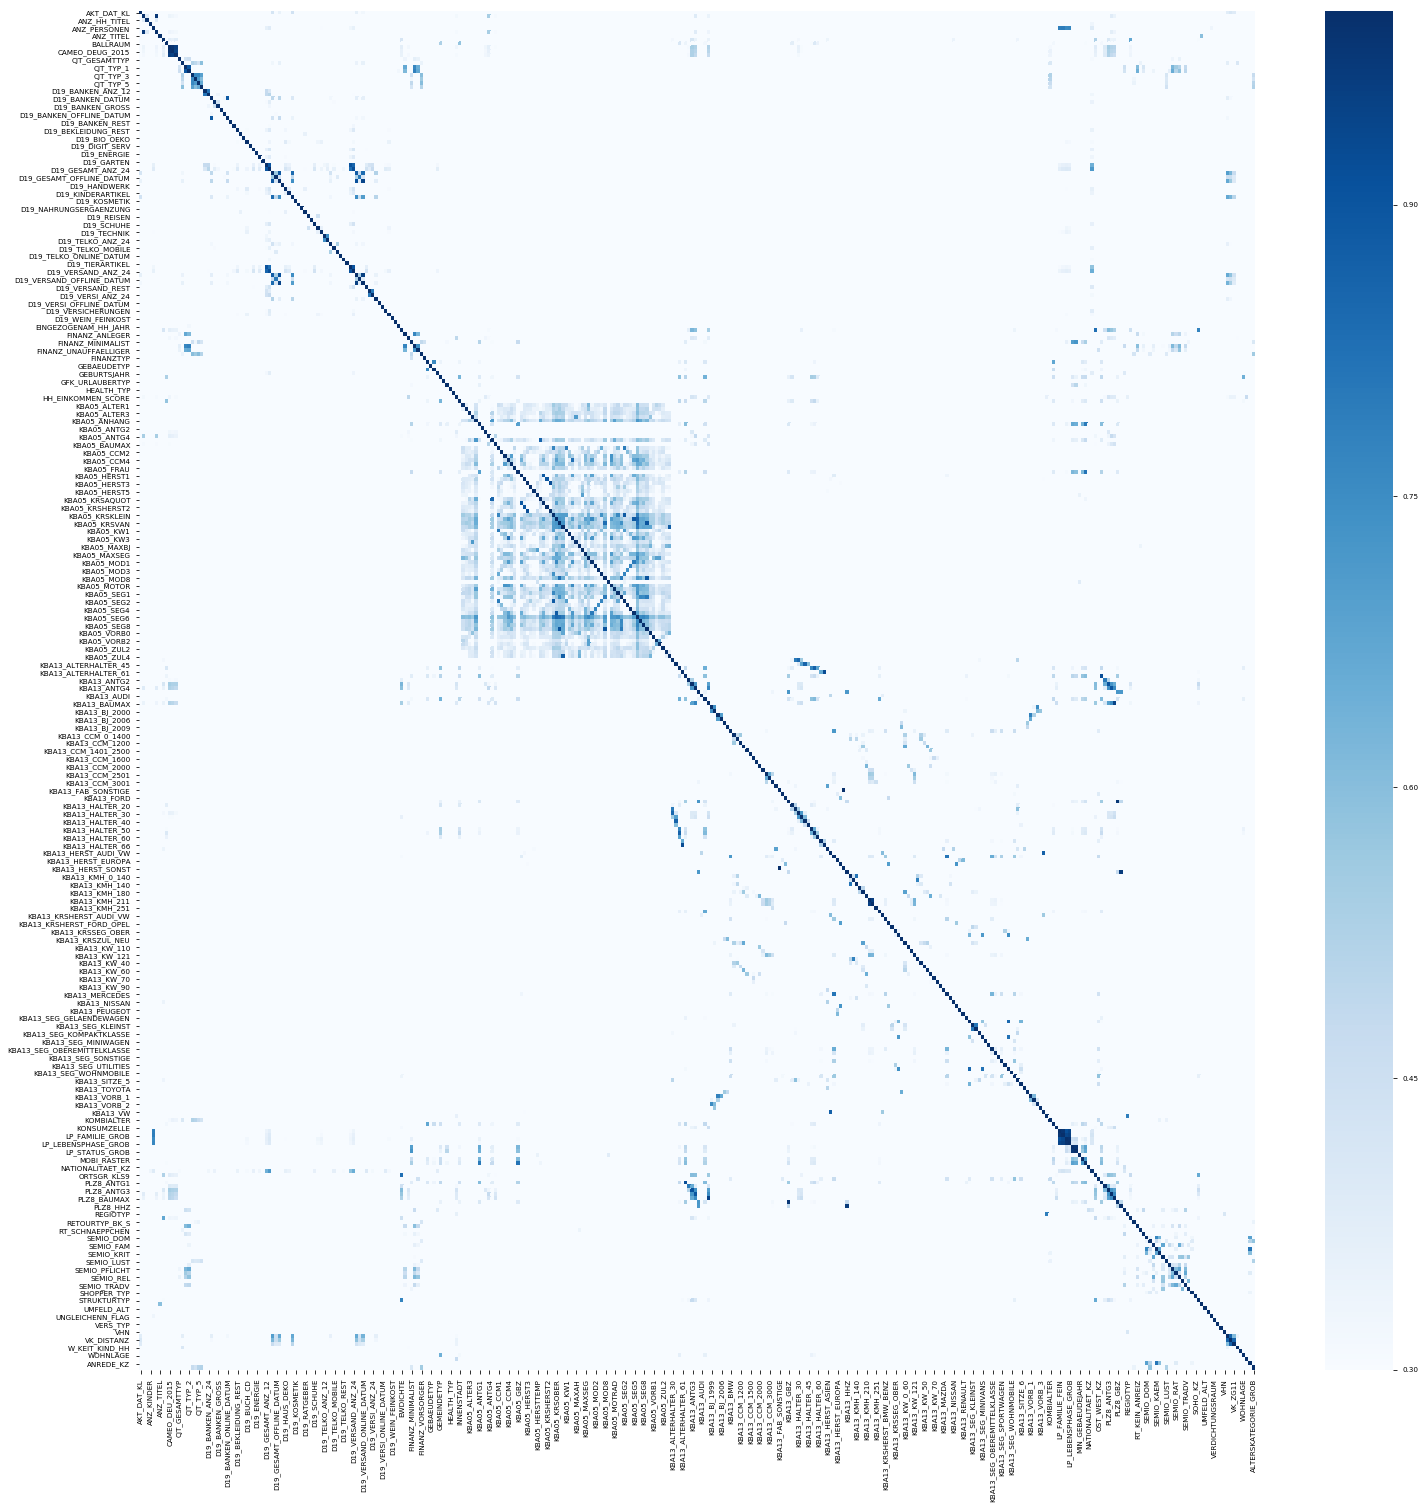

In [31]:
sns.set_context("paper", font_scale=0.9)
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix_azdias_2, cmap="Blues", vmin=0.3)

In [32]:
azdias_td_2_index = azdias_td_2.index
azdias_td_2_columns = azdias_td_2.columns

In [33]:
# Due to the high correlation between the different columns, we conduct a PCA to further reduce the features, but first normalization between 0 and 1
list_azdias_td_2_subsets = hps.split_dataset(azdias_td_2, 100000)
azdias_td_2 = None

In [34]:
list_azdias_td_3 = hps.iterator_datasets_nomalization(list_azdias_td_2_subsets)
list_azdias_td_2_subsets = None
azdias_td_3 = pd.concat(list_azdias_td_3)
list_azdias_td_3 = None

1
2
3
4
5
6
7
8
9


In [35]:
azdias_td_3.index = azdias_td_2_index
azdias_td_3.columns = azdias_td_2_columns
azdias_td_3.head(10)

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.432021,0.022000,0.002683,0.017087,0.038411,0.020759,0.002167,0.270395,0.524047,1.000000,...,0.605903,0.502273,0.547196,0.497711,0.656209,0.8636,0.505057,0.4,0.0,0.125
1,1.000000,0.029178,0.000000,0.000000,0.044444,0.032698,0.000000,0.250000,0.833333,0.795455,...,1.000000,0.700000,0.833333,0.900000,0.500000,1.0000,0.500000,0.8,1.0,0.000
2,1.000000,0.026525,0.000000,0.000000,0.022222,0.019074,0.000000,0.250000,0.166667,0.340909,...,0.500000,0.800000,0.666667,0.500000,0.500000,1.0000,0.250000,0.8,1.0,0.250
3,0.000000,0.002653,0.000000,0.000000,0.000000,0.005450,0.000000,0.125000,0.500000,0.113636,...,0.000000,0.600000,0.750000,1.000000,0.656209,1.0000,0.875000,0.4,1.0,0.375
4,0.000000,0.007958,0.000000,0.000000,0.088889,0.008174,0.000000,0.375000,0.166667,0.568182,...,0.500000,0.200000,0.333333,0.300000,0.333333,1.0000,0.375000,0.6,0.0,0.250
5,0.000000,0.013263,0.000000,0.000000,0.022222,0.005450,0.000000,0.125000,0.833333,0.840909,...,0.500000,0.900000,0.500000,0.300000,1.000000,1.0000,0.875000,0.6,1.0,0.000
6,1.000000,0.010610,0.000000,0.000000,0.022222,0.008174,0.000000,0.375000,0.833333,0.295455,...,0.500000,0.600000,0.750000,0.900000,0.500000,1.0000,0.625000,0.6,1.0,0.125
7,0.000000,0.015915,0.000000,0.000000,0.022222,0.013624,0.000000,0.125000,0.166667,0.181818,...,0.500000,0.900000,0.916667,0.800000,0.833333,1.0000,0.125000,0.0,0.0,0.000
8,1.000000,0.005305,0.066667,0.000000,0.022222,0.005450,0.000000,0.125000,0.333333,0.000000,...,1.000000,0.700000,0.833333,0.700000,0.833333,0.8750,0.125000,1.0,0.0,0.250
9,0.500000,0.023873,0.000000,0.000000,0.022222,0.019074,0.000000,0.125000,0.833333,0.090909,...,1.000000,0.000000,0.000000,0.000000,0.666667,0.2500,0.875000,0.6,1.0,0.250


In [36]:
azdias_td_3.describe()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.427744,0.018480,0.002431,0.020848,0.072016,0.020018,0.001549,0.270984,0.525508,0.586501,...,0.604331,0.500122,0.544346,0.494599,0.655567,0.863597,0.506604,0.472488,0.522098,0.222175
std,0.435692,0.033360,0.018049,0.066353,0.057137,0.035851,0.025766,0.118270,0.344280,0.303578,...,0.271089,0.273174,0.258866,0.265081,0.307047,0.230267,0.230606,0.270541,0.499512,0.133597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.003731,0.000000,0.000000,0.032258,0.004454,0.000000,0.250000,0.166667,0.295455,...,0.500000,0.300000,0.416667,0.300000,0.500000,0.863600,0.375000,0.400000,0.000000,0.125000
50%,0.375000,0.010929,0.000000,0.000000,0.054054,0.011299,0.000000,0.250000,0.525063,0.613636,...,0.603808,0.500000,0.547196,0.500000,0.666667,1.000000,0.500000,0.400000,1.000000,0.250000
75%,1.000000,0.021359,0.000000,0.000000,0.090909,0.021869,0.000000,0.375000,0.833333,0.863636,...,0.750000,0.700000,0.750000,0.700000,1.000000,1.000000,0.625000,0.600000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
N_COMPONENTS = len(azdias_td_3.columns)

In [38]:
# conduct PCA analysis
pca = PCA().fit(azdias_td_3)

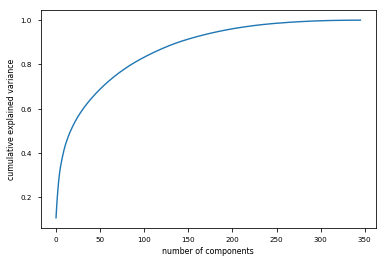

In [39]:
#plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [40]:
#Get principal components
s=pd.DataFrame(pca.singular_values_)
v=pd.DataFrame(pca.components_)

In [41]:
# test cell
n_top_components = 110 # select a value for the number of top components

# calculate the explained variance
exp_variance = hps.explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8507474950159595


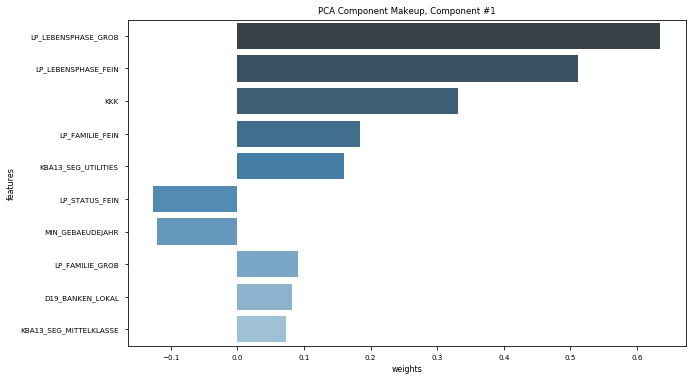

In [47]:
# display makeup of first component
num=1
hps.display_component(v, azdias_td_3.columns.values, component_num=1, N_COMPONENTS=N_COMPONENTS, n_weights=10)

In [48]:
#Decide on number of PCA list
pca_final = PCA(150)
compressed_azdias_td_3 = pca_final.fit_transform(azdias_td_3)

In [49]:
PCA_column_names = ['c_' + str(i + 1) for i in range(150)]

In [50]:
azdias_td_cp_3 = hps.create_transformed_df(compressed_azdias_td_3)
azdias_td_cp_3.columns = PCA_column_names

In [51]:
azdias_td_cp_3.head(10)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_141,c_142,c_143,c_144,c_145,c_146,c_147,c_148,c_149,c_150
0,-0.940959,-1.292724,-0.599544,0.069410,-0.038011,-0.116565,-0.297340,1.483230,-0.189986,-0.012324,...,0.058067,-0.186973,0.017356,0.169809,0.014135,0.166419,0.133873,-0.060349,-0.007991,0.012419
1,-1.698720,1.406102,-1.091438,0.991935,-0.610289,-0.087392,0.410088,-0.822643,-0.395505,0.442724,...,-0.144400,-0.031455,-0.168960,0.023755,0.282817,-0.141684,-0.364975,-0.304463,-0.127808,-0.112277
2,0.075493,0.259522,-0.803335,1.321752,-0.867229,-0.265853,1.117079,-1.189230,0.452384,-0.474703,...,0.021149,-0.260271,-0.002695,0.136041,-0.018596,-0.096008,0.024971,-0.068580,0.081534,-0.042328
3,1.493806,-1.482566,-0.698831,0.461538,-0.373422,-0.117947,-0.209348,-1.120285,-0.686432,0.484640,...,-0.014773,-0.129617,0.081715,-0.152110,-0.047357,-0.137216,0.027770,-0.160093,0.069671,-0.211539
4,1.393217,1.508875,1.959325,0.404456,0.863899,-0.021667,-0.975171,0.118500,-0.789138,-0.477562,...,-0.300326,0.231933,0.124645,0.049988,0.267594,-0.240987,-0.036414,-0.023577,-0.125884,0.009285
5,0.557193,-0.613681,-0.574513,0.447376,-0.014920,-0.173497,0.161206,-0.123480,-1.087223,-0.693967,...,0.001461,-0.007856,-0.224954,-0.027672,-0.258169,0.163784,0.136076,0.106383,-0.103656,0.054101
6,-0.701115,0.637016,-2.045778,-0.193887,-0.566011,-0.205353,-0.163734,-0.422043,0.976625,-0.394693,...,-0.049860,-0.154070,-0.115322,-0.097709,0.074219,0.082000,-0.074391,0.385197,-0.070955,0.036123
7,-0.027647,-0.525865,-0.662858,1.064346,1.748021,-0.176905,0.788512,-0.461813,0.479724,-0.550468,...,0.120155,0.268500,0.037924,0.050822,-0.098636,0.050736,0.242366,0.187349,-0.311418,0.119925
8,0.178028,-0.735876,-0.743874,2.147164,0.793837,-0.328024,0.719823,-0.772318,0.677985,-0.339336,...,0.108817,0.133779,0.158641,0.070254,-0.059398,-0.117918,0.288284,-0.392308,-0.086927,0.177603
9,0.943448,0.846092,0.845289,2.897276,-1.051785,-0.193484,1.046801,-0.453693,-0.532545,-1.229794,...,0.252943,-0.231774,0.193532,0.237550,0.093925,0.063005,0.284114,-0.191834,-0.218186,-0.003094


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
#Find the right K Cluster
wcss = []

for i in range(1, 20):
    start = time.time()
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(azdias_td_cp_3)
    wcss.append(kmeans.inertia_)
    stop = time.time()
    duration = stop-start
    print(duration)
    
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [52]:
# The right value of K is - 8 is the number to go
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(azdias_td_cp_3)

In [53]:
# count up the points in each cluster
cluster_df = pd.DataFrame(pred_y)[0].value_counts().sort_index()
print(cluster_df)

0    143864
1     86143
2    119914
3    125218
4    120447
5    135109
6    145740
7     14786
Name: 0, dtype: int64


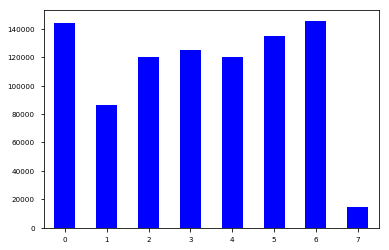

In [54]:
ax = cluster_df.plot.bar(rot=0, color='blue')

In [56]:
cluster_center_arrray = kmeans.cluster_centers_
print(len(cluster_center_arrray))

8


In [58]:
cluster_center_df = hps.create_transformed_df(cluster_center_arrray)
print(cluster_center_df.shape)
cluster_center_df.head(8)

(8, 150)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.982857,-0.868940,1.062390,-0.320989,-0.125535,-0.270602,0.052362,-0.181955,-0.037981,-0.183648,...,0.004559,0.005260,-0.001352,0.004120,-0.001862,0.003722,-0.010245,-0.003097,0.000932,-0.005166
1,-1.045958,-0.594804,-1.150066,0.214988,-0.315553,-0.095121,-0.240272,1.519557,-0.121407,-0.044285,...,-0.012894,-0.003665,-0.009551,0.003634,-0.007496,-0.004881,0.002659,-0.005307,0.000100,0.004957
2,1.262459,1.603797,-0.108561,-0.008111,-0.039606,0.096318,-0.017973,0.066770,-0.072624,-0.181821,...,0.001570,-0.007479,-0.010494,0.009321,-0.002748,0.006014,-0.008928,-0.008523,-0.001535,-0.010194
3,2.183811,-0.010911,0.744361,0.066380,-0.083816,-0.010249,-0.068872,0.154565,0.052556,0.129038,...,-0.005263,0.008389,0.008393,-0.009865,0.006777,-0.009071,0.005095,0.004877,-0.000181,0.011211
4,-1.939945,1.161207,0.596041,-0.062482,0.191561,-0.137275,0.022070,-0.136085,-0.033332,0.312679,...,0.000223,-0.007620,0.004861,-0.004535,0.002245,-0.001094,0.012043,0.001244,-0.002098,0.004788
5,-0.472110,0.460789,-1.213223,0.204564,0.145436,-0.099677,0.147087,-0.477850,0.109435,-0.086308,...,0.001854,0.007455,0.006472,-0.003817,-0.001963,-0.000996,-0.007080,0.004223,0.004321,-0.003117
6,0.855647,-1.387728,-0.331503,-0.045050,0.142714,-0.130198,0.039162,-0.322137,0.031608,0.083719,...,0.004118,-0.004369,-0.001058,0.000808,0.001515,0.003631,0.008376,0.003328,-0.001230,0.000501
7,-1.395107,-0.981892,0.439830,0.457833,-0.205732,5.805164,-0.290547,-0.281947,0.180532,-0.157493,...,0.003247,-0.003196,-0.005492,0.010559,0.011374,0.002489,-0.002546,0.007335,-0.005943,-0.006355


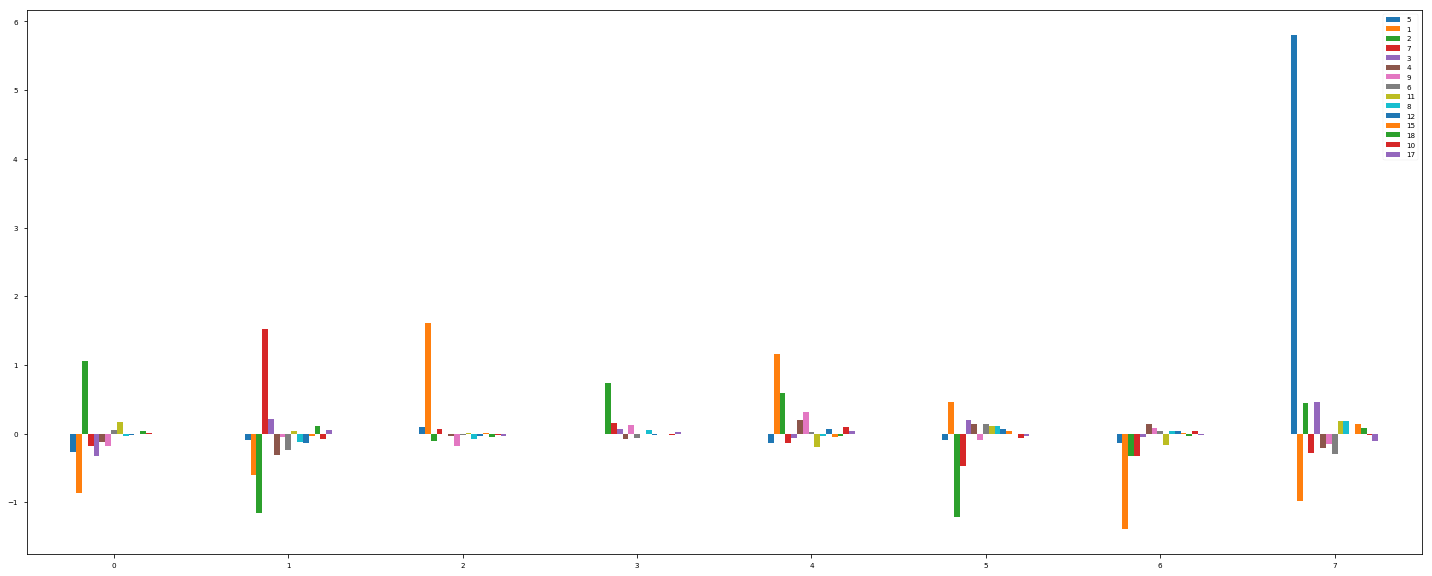

In [59]:
#Calculate the variance of means between clusters within each variable and select the top 5 variables with the highest variance
results = pd.DataFrame(columns=['Variable', 'Var'])

for column in cluster_center_df.columns[1:]:
    results.loc[len(results), :] = [column, np.var(cluster_center_df[column])]
    selected_columns = list(results.sort_values('Var', ascending=False,).head(15).Variable.values)

tidy = cluster_center_df[selected_columns]
tidy.plot.bar(rot=0,figsize=(25,10))

In [60]:
# Save s-file from PCA analyse und dazugehörige labels, PCCs
import pickle
filename = 'finalized_kmeans_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [68]:
consumer_td_cp_3 = hps.prepare_customer_file(customers)

(191652, 369)
       PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
0  COSMETIC_AND_FOOD    MULTI_BUYER                0
1               FOOD   SINGLE_BUYER                0
2  COSMETIC_AND_FOOD    MULTI_BUYER                0
3           COSMETIC    MULTI_BUYER                0
4               FOOD    MULTI_BUYER                0
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(271), int64(89), object(6)
memory usage: 535.2+ MB
None
2. Successful replacement of incorrectly placed missing values
(191652, 346)
3. Object transformation successful, list is empty
1
2
4. Normalization and mean replacement for PCA successful
          AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL     ANZ_KINDER  \
count  191652.000000        191652.000000  191652.000000  191652.000000   
mean        0.093430             0.011207       0.002930       0.018204   
std         0.213836             0.028051       0.020241       0.057373   
min         0.000000             0.000000       0.000000       0.000000   
25%         0.000000             0.002639       0.000000       0.000000   
50%         0.000000             0.005277       0.000000       0.000000   
75%         0.094828             0.013008       0.002861       0.017188   
max      

In [69]:
#Predict customer in dataset
pred_y_customer = kmeans.predict(consumer_td_cp_3)

In [70]:
# count up the points in each cluster customer
cluster_df_2 = pd.DataFrame(pred_y_customer)[0].value_counts().sort_index()
print(cluster_df_2)

0    11308
1     4870
2    29145
3    37769
4    53718
5    20820
6    34022
Name: 0, dtype: int64


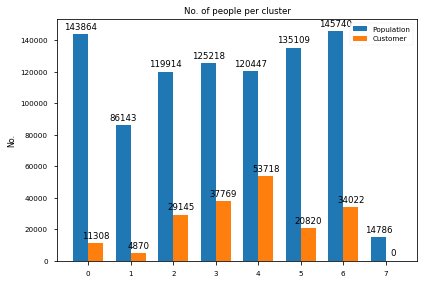

In [71]:
labels = [0, 1, 2, 3, 4, 5, 6, 7]
pred_population_values = cluster_df.values
pred_customer_values = np.append(cluster_df_2.values, [0])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pred_population_values, width, label='Population')
rects2 = ax.bar(x + width/2, pred_customer_values, width, label='Customer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No.')
ax.set_title('No. of people per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

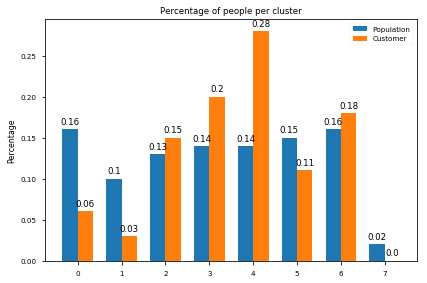

In [72]:
labels = [0, 1, 2, 3, 4, 5, 6, 7]
pred_population_values_percentage_1 = cluster_df.values / sum(cluster_df.values)
pred_population_values_percentage = np.round(pred_population_values_percentage_1, decimals=2)
pred_customer_values_percentage_1 = np.append(cluster_df_2.values, [0]) / sum(cluster_df_2.values)
pred_customer_values_percentage = np.round(pred_customer_values_percentage_1, decimals=2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pred_population_values_percentage, width, label='Population')
rects2 = ax.bar(x + width/2, pred_customer_values_percentage, width, label='Customer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Percentage of people per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Cluster 3 and 4 are overrepresented, cluster 0 and 1 are underrepresented

Component 2 - Positively related to Cluster 3 and 4, strongly positively related to Cluster 4, strongly negatively related to Cluster 1

Component 1 - Strongly positively related to Cluster 4, negatively related to Cluster 0 and 1

Component 7 - Strongly positively related to Cluster 1

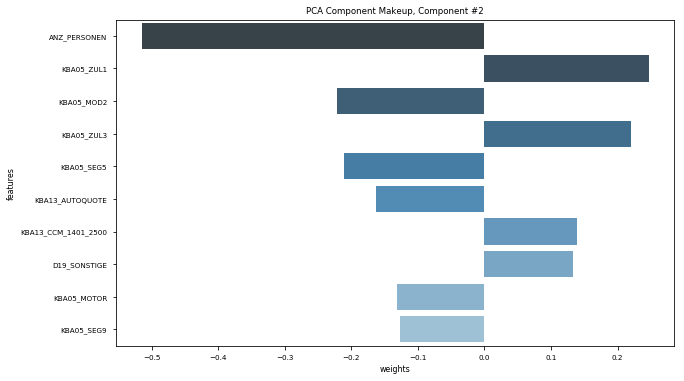

In [76]:
# display makeup of first component
num=2
display_component(v, azdias_td_3.columns.values, component_num=num, N_COMPONENTS=N_COMPONENTS, n_weights=10)

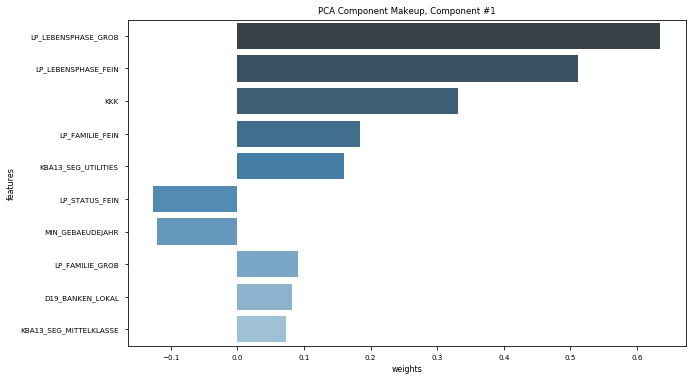

In [75]:
num = 1
display_component(v, azdias_td_3.columns.values, component_num=num, N_COMPONENTS=N_COMPONENTS, n_weights=10)

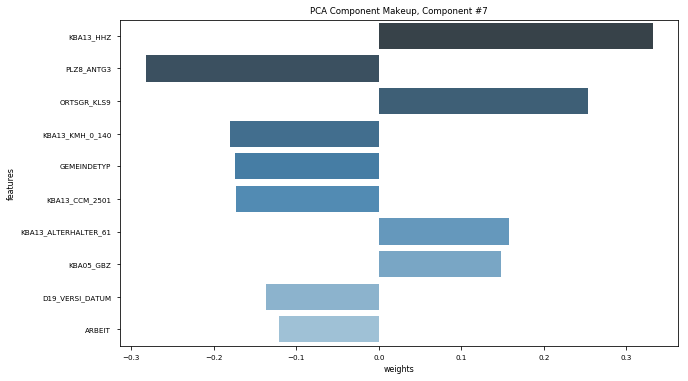

In [77]:
num=7
display_component(v, azdias_td_3.columns.values, component_num=num, N_COMPONENTS=N_COMPONENTS, n_weights=10)

In [78]:
pred_y.shape

(891221,)

In [105]:
azdias_td_3['Cluster'] = pred_y

In [90]:
azdias_td_3.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Cluster,LEBENSPHASE_GROB
0,0.432021,0.022000,0.002683,0.017087,0.038411,0.020759,0.002167,0.270395,0.524047,1.000000,...,0.547196,0.497711,0.656209,0.8636,0.505057,0.4,0.0,0.125,1,1
1,1.000000,0.029178,0.000000,0.000000,0.044444,0.032698,0.000000,0.250000,0.833333,0.795455,...,0.833333,0.900000,0.500000,1.0000,0.500000,0.8,1.0,0.000,5,5
2,1.000000,0.026525,0.000000,0.000000,0.022222,0.019074,0.000000,0.250000,0.166667,0.340909,...,0.666667,0.500000,0.500000,1.0000,0.250000,0.8,1.0,0.250,5,5
3,0.000000,0.002653,0.000000,0.000000,0.000000,0.005450,0.000000,0.125000,0.500000,0.113636,...,0.750000,1.000000,0.656209,1.0000,0.875000,0.4,1.0,0.375,6,6
4,0.000000,0.007958,0.000000,0.000000,0.088889,0.008174,0.000000,0.375000,0.166667,0.568182,...,0.333333,0.300000,0.333333,1.0000,0.375000,0.6,0.0,0.250,2,2


In [114]:
#Get dimensions with highest weights
list_1 = hps.get_component_list(v, azdias_td_3.columns.values, component_num=1, N_COMPONENTS=N_COMPONENTS, n_weights=10)
list_7 = hps.get_component_list(v, azdias_td_3.columns.values, component_num=7, N_COMPONENTS=N_COMPONENTS, n_weights=10)
list_2 = hps.get_component_list(v, azdias_td_3.columns.values, component_num=2, N_COMPONENTS=N_COMPONENTS, n_weights=10)

In [138]:
selected_columns = []
selected_columns.extend(list_1['features'].tolist())
selected_columns.extend(list_7['features'].tolist())
selected_columns.extend(list_2['features'].tolist())
selected_columns = list(dict.fromkeys(selected_columns))
print(selected_columns)

['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'KKK', 'LP_FAMILIE_FEIN', 'KBA13_SEG_UTILITIES', 'LP_STATUS_FEIN', 'MIN_GEBAEUDEJAHR', 'LP_FAMILIE_GROB', 'D19_BANKEN_LOKAL', 'KBA13_SEG_MITTELKLASSE', 'KBA13_HHZ', 'PLZ8_ANTG3', 'ORTSGR_KLS9', 'KBA13_KMH_0_140', 'GEMEINDETYP', 'KBA13_CCM_2501', 'KBA13_ALTERHALTER_61', 'KBA05_GBZ', 'D19_VERSI_DATUM', 'ARBEIT', 'ANZ_PERSONEN', 'KBA05_ZUL1', 'KBA05_MOD2', 'KBA05_ZUL3', 'KBA05_SEG5', 'KBA13_AUTOQUOTE', 'KBA13_CCM_1401_2500', 'D19_SONSTIGE', 'KBA05_MOTOR', 'KBA05_SEG9']


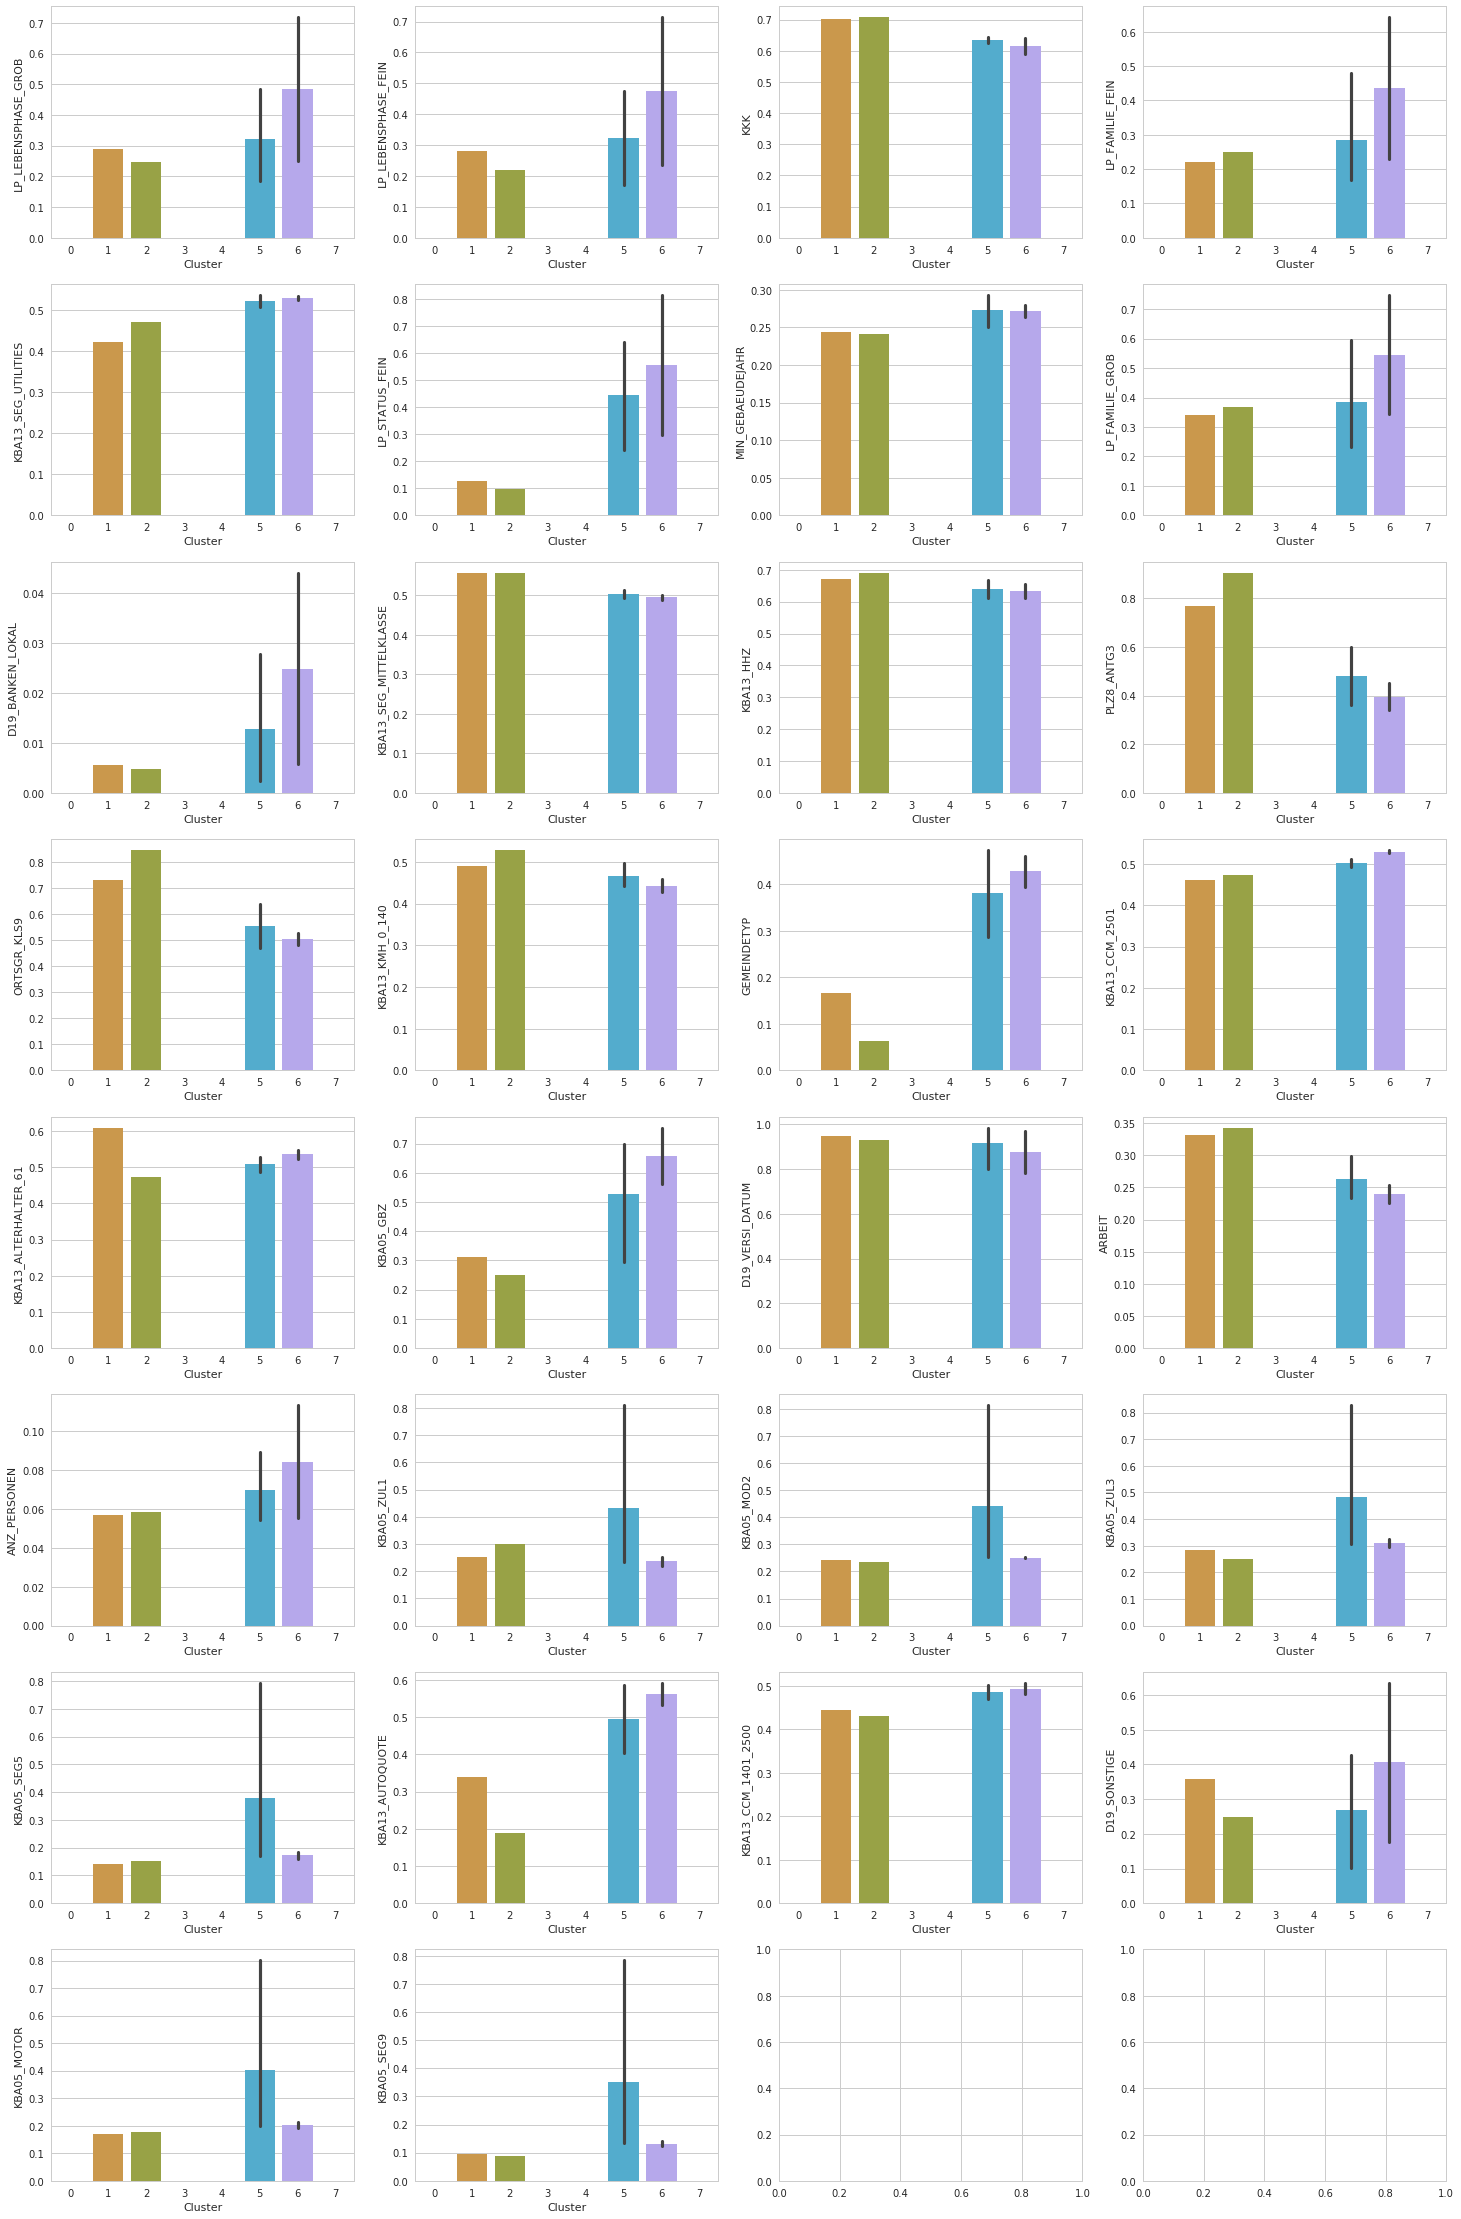

In [137]:
cols = 4
rows = len(selected_columns) // cols + 1
sns.set(style="whitegrid")

fig, axes = plt.subplots(rows, cols, figsize=(25,5*rows))
x = 0
y = 0    

for i in range(len(selected_columns)):
    means = azdias_td_3.groupby('Cluster')[selected_columns[i]].mean()
    sns.barplot(x=azdias_td_3["Cluster"], y=means, ax=axes[x, y])
    y += 1
    
    if y / 4 == 1:
        x += 1
        y = 0

plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# load numpy array from csv file
from numpy import loadtxt

# load array
train_data = loadtxt(r'/home/workspace/processed_train_data_v8_2.csv', delimiter=',')
mailout_train_v8 = train_data

In [8]:
mailout_train.shape

(42962, 367)

General information about the dataset.

In [9]:
print("Description about data types in customer database:")
print(mailout_train.info())

Description about data types in customer database:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB
None


A general overview of the RESPONSE column shows, that there is a high tendency towards no response with only ~1% of all Responses positive. The design needs to incorporate other metrics than the accuracy and needs to be trained with equal amounts of positive responses in the train and test set.

First impression of data RESPONSE:
0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64
Column data types: int64
Sum empty values (absolute/percentage): 0 / 0.0
Rows values unique identifier (Length dataset vs. unique values): False
0    42430
1      532
Name: RESPONSE, dtype: int64


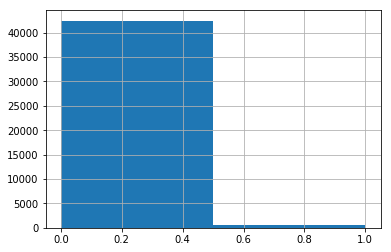

In [10]:
hp.column_information(mailout_train['RESPONSE'])

1. The first task will be to remove all wrongly inserted "unknown" values with NaN.

In [11]:
mailout_train_v2 = hp.replace_missing_data(mailout_train)

Successful replacement of incorrectly placed missing values


2. The next is identification of columns with more than 25% NaN values.

In [12]:
mailout_train_v3, excluded_columns = hp.removal_NaN_columns(mailout_train_v2, 25)

15 columns to be excluded: Index(['D19_TELKO_ONLINE_QUOTE_12', 'ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ',
       'ANZ_TITEL', 'ALTER_KIND2', 'ALTER_KIND1', 'KBA05_ANTG4', 'KBA13_ANTG4',
       'PLZ8_ANTG4', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'EXTSEL992',
       'ALTER_HH'],
      dtype='object')
Remaining columns in dataset: (42962, 352)


In [13]:
mailout_train_v3 = mailout_train_v3.drop(labels=["EINGEFUEGT_AM", "LNR", "D19_LETZTER_KAUF_BRANCHE"], axis=1)
mailout_train_v3.shape

(42962, 349)

3. Transform all object like columns to integer/floats 

In [14]:
object_columns = mailout_train_v3.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ']


In [15]:
mailout_train_v3['CAMEO_DEUG_2015'] = mailout_train_v3.astype({'CAMEO_DEUG_2015': 'float'}).dtypes

In [16]:
mailout_train_v3['CAMEO_INTL_2015'] = mailout_train_v3.astype({'CAMEO_INTL_2015': 'float'}).dtypes

In [17]:
mailout_train_v4 = pd.get_dummies(mailout_train_v3, columns=['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], drop_first=True)

In [18]:
mailout_train_v4.shape

(42962, 389)

4. Next, we drop all rows with a higher NaN values above threshold of 30% and not "RESPONSE = 1"

In [19]:
#mailout_train_v5 = hp.removal_NaN_rows(mailout_train_v4, 30)
mailout_train_v5 = mailout_train_v4

5. We also want to drop highly correlated columns:

In [20]:
# Create correlation matrix
corr_matrix = mailout_train_v5.corr().abs()

In [21]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [22]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))

9


In [23]:
mailout_train_v6 = mailout_train_v5.drop(mailout_train_v5[to_drop], axis=1)
mailout_train_v6.shape

(42962, 380)

6. Next we need to get the result array from the PCA analysis, so it does not get reduced in the analysis

In [24]:
mailout_response = mailout_train_v6.filter(items = ['RESPONSE'], axis = 1).values.flatten()
mailout_train_v6 = mailout_train_v6.drop(['RESPONSE'], axis = 1)

In [25]:
print(mailout_train_v6.shape)
print(mailout_response.shape)

(42962, 379)
(42962,)


7. Lastly, we want to conduct a PCA analysis, therefore we replace missing values with an Iterative Imputer and MinMax the values

In [26]:
binary = []
numerical = []

for column in mailout_train_v6.columns:
    if mailout_train_v6[column].nunique(dropna = True) <= 2:
        binary.append(column)
    else:
        numerical.append(column)
        
#check
check = len(numerical) + len(binary)
print(check == len(mailout_train_v6.columns))

True


In [33]:
mailout_train_v7, s_imp, KNNimp = hp.imputer(mailout_train_v6, numerical, binary)

In [34]:
mailout_train_v8, scaler = hp.standard_scaler(mailout_train_v7, numerical)

In [35]:
mailout_train_v8.describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
count,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,...,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,-1.968125e-17,-9.890242e-17,3.572395e-17,1.852353e-17,-5.027815e-17,-6.350924e-17,1.662156e-16,4.678845e-16,-4.416704e-16,-7.525184e-17,...,0.037172,0.022764,0.029491,0.027187,0.010824,0.011987,0.010079,0.015572,0.008798,0.622690
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,0.189186,0.149153,0.169181,0.162629,0.103473,0.108830,0.099887,0.123813,0.093388,0.484719
min,-3.335729e-01,-1.578006e+00,-5.069267e-01,-1.212468e-01,-2.050083e-01,-1.435686e+00,-2.027890e+00,-1.587524e+00,-1.304916e+00,-2.014840e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.335729e-01,-5.109656e-01,-4.343214e-01,-1.212468e-01,-2.050083e-01,-6.633719e-01,-5.832312e-01,-1.088193e+00,-7.391175e-01,-6.239018e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.335729e-01,1.368803e-01,-2.891108e-01,-1.212468e-01,-2.050083e-01,-3.544462e-01,3.590822e-02,-8.952918e-02,-1.733191e-01,7.670361e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-2.188968e-01,7.085090e-01,1.610421e-01,-1.212468e-01,-2.050083e-01,1.089423e-01,1.067807e+00,9.091343e-01,9.582778e-01,7.670361e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.253472e+00,3.185567e+00,3.129419e+01,5.817109e+01,1.628136e+01,1.709985e+01,6.227302e+00,1.408466e+00,1.524076e+00,7.670361e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


8. Test prior to PCA that all values have been transformed correctly

In [38]:
from numpy import savetxt

# save to csv file
savetxt(r'/home/workspace/processed_train_data_v8_2.csv', mailout_train_v8, delimiter=',')

In [39]:
dump(scaler, open('scaler.pkl', 'wb'))

In [40]:
dump(s_imp, open('s_imp.pkl', 'wb'))

In [41]:
dump(KNNimp, open('KNNimp.pkl', 'wb'))

9. Start PCA analysis to reduce features

In [42]:
N_COMPONENTS = len(mailout_train_v8.columns)

# Conduct PCA analysis
pca = PCA().fit(mailout_train_v8)

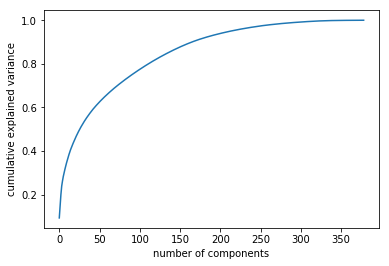

In [43]:
#plot the PCA analysis variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [44]:
#Get principal components
s=pd.DataFrame(pca.singular_values_)
v=pd.DataFrame(pca.components_)

In [45]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
hp.explained_variance(s, 150)

0.8759160233961569

In [46]:
pca = PCA(n_components = 0.99)
pca.fit(mailout_train_v8)
mailout_train_v9 = pca.transform(mailout_train_v8)

In [47]:
mailout_train_v9.shape

(42962, 294)

10. Train first model to see the performance

In [53]:
#Define model
model = xgb.XGBClassifier()

#Define evaluation procedure
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

#Evaluate model
scores = cross_val_score(model, mailout_train_v8, mailout_response, scoring='roc_auc', cv=cv)

#Summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.68153


In [57]:
#Define model
GB_model = GradientBoostingClassifier()

#Evaluate model
scores = cross_val_score(GB_model, mailout_train_v8, mailout_response, scoring='roc_auc', cv=cv)

#Summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.76180


In [59]:
#Define model
model = xgb.XGBClassifier()

#Evaluate model
scores = cross_val_score(model, mailout_train_v9, mailout_response, scoring='roc_auc', cv=cv)

#Summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.56908


In [60]:
#Define model
GB_model = GradientBoostingClassifier()

#Evaluate model
scores = cross_val_score(GB_model, mailout_train_v9, mailout_response, scoring='roc_auc', cv=cv)

#Summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.58091


Overall, the prediction without PCA runs better than with PCA. Therefore, the next steps are conducted without PCA. The GradientBoostingClassifier works better than the XGBoost, but both will be optimized. The next steps are as follows:

1. N_Estimtor: Try N-Estimators until no improvement (https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn) (https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e) 
3. Hyperparameter Enhancement: (https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)
    1. GradientBoosting:
    2. XGBoost (https://github.com/ray-project/tune-sklearn/blob/master/examples/xgbclassifier.py, https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e):

In [84]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(mailout_train_v8, mailout_response, stratify=mailout_response, test_size = 0.3, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))

print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

[0]	validation_0-auc:0.73457
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.73835
[2]	validation_0-auc:0.74368
[3]	validation_0-auc:0.77065
[4]	validation_0-auc:0.76662
[5]	validation_0-auc:0.75526
[6]	validation_0-auc:0.76053
[7]	validation_0-auc:0.75856
[8]	validation_0-auc:0.75614
[9]	validation_0-auc:0.75619
[10]	validation_0-auc:0.75130
[11]	validation_0-auc:0.74916
[12]	validation_0-auc:0.74729
[13]	validation_0-auc:0.74421
[14]	validation_0-auc:0.74714
[15]	validation_0-auc:0.74916
[16]	validation_0-auc:0.74660
[17]	validation_0-auc:0.75057
[18]	validation_0-auc:0.75114
[19]	validation_0-auc:0.75051
[20]	validation_0-auc:0.74904
[21]	validation_0-auc:0.74898
[22]	validation_0-auc:0.74300
[23]	validation_0-auc:0.74500
Stopping. Best iteration:
[3]	validation_0-auc:0.77065

0.7706504340482363
best score: 0.77065, best iteration: 3, best ntree limit 4


In [29]:
xg_clf_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#Hyperparameter Optimization
params = {"learning_rate" : [0.10, 0.20] ,
          "n_estimators" : [5, 10, 20],
          "max_depth" : [3],
          "subsample": [0.8, 1],
          "colsample_bytree" : [0,3, 0.5],
          "gamma": [0],
          "scale_pos_weight": [10, 20]}

clf = GridSearchCV(xg_clf_model, params, n_jobs=1, cv=cv, scoring='roc_auc', verbose=2, refit=True)

clf.fit(mailout_train_v8, mailout_response)

# Get the estimator and predict
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)
best_clf = clf.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[17:57:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:57:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:57:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[

[17:58:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[17:58:07] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[17:58:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[17:58:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:36] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:58:36] INFO: xgboost/src/tree/updater_prune.cc:101: 

[17:59:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:09] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:59:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[17:59:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:59:13] INFO: xgboost/src/tree/updater_prune.cc:101: 

[17:59:38] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:59:38] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:38] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[17:59:38] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[17:59:40] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:40] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[17:59:40] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[17:59:41] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:00:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:00:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:00:15] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:00:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:00:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:00:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:00:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:00:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:00:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:00:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:00:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:01:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:01:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[18:01:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:01:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:01:48] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:49] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[18:01:49] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[18:01:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:01:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[18:01:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:01:51] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:01:51] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:01:52] INFO: xgboost/src/tree/updater_prune.cc:101: tree p

[18:02:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:02:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:02:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:21] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:02:22] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:02:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:02:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:02:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:03:21] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:22] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:22] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:23] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:23] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:24] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:24] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:24] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:03:25] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:03:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:03:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:03:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:03:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:03:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:03:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:04:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:00] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:04:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:04:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:04:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:04:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:04:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:04:30] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:04:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:05:02] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:02] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:02] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:03] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:05:03] INFO: xgboost/src/tree/updater_prune.cc:101: tree pr

[18:05:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 2 pruned nodes, max_depth=2
[18:05:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:05:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:05:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:05:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:06:01] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:06:02] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:03] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:03] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:06:04] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:04] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:04] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:06:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:39] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[18:06:40] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:41] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:06:41] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:06:41] INFO: xgboost/src/tree/updater_prune.cc:101: tree pr

[18:07:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:07:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:07:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:07:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:07:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:07:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:07:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:07:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:07:10] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:07:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:07:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:07:48] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:07:48] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:07:48] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:07:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:07:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:07:50] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:07:50] INFO: xgboost/src/tree/updater_prune.cc:101: tre

[18:08:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:08:20] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:08:53] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:08:54] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:08:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:08:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:08:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:08:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:08:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[18:08:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:08:59] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:09:29] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:09:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:09:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:09:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[18:09:30] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:09:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:09:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:09:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:09:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree

[18:10:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:06] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:07] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:08] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:10:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:10:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:10:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:10:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:10:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:10:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:10:47] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:11:16] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:11:16] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:11:16] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:11:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:11:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:11:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:11:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:11:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[18:11:20] INFO: xgboost/src/tree/updater_prune.cc:101: tr

[18:11:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:11:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:11:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[18:11:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:11:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:12:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:12:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:12:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[18:12:00] INFO: xgboost/src/tree/updater_prune.cc:101: tree pr

[18:12:31] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:31] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:12:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:12:32] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:12:34] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:13:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:14] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:13:42] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:13:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:45] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:13:45] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:14:17] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:14:18] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:14:19] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:14:19] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[18:14:20] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[18:14:21] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:14:21] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:14:22] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:14:23] INFO: xgboost/src/tree/updater_prune.cc:101: tree

[18:14:55] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:14:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[18:14:56] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:14:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:14:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:14:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:14:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 2 pruned nodes, max_depth=4
[18:14:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[18:14:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pr

[18:15:31] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[18:15:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:15:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:15:33] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2 pruned nodes, max_depth=0
[18:15:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:15:34] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:15:35] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2 pruned nodes, max_depth=0
[18:15:36] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:15:36] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:16:10] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:16:11] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:16:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:16:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 2 pruned nodes, max_depth=0
[18:16:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:16:12] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:16:13] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:16:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[18:16:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pru

[18:16:42] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:43] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:44] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:46] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:16:46] INFO: xgboost/src/tree/updater_prune.cc:101: 

[18:17:24] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:17:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 2 pruned nodes, max_depth=4
[18:17:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:26] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[18:17:28] INFO: xgboost/src/tree/updater_prune.cc:101: tree p

[18:17:57] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[18:17:58] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:17:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[18:17:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:17:59] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:18:01] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:18:01] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:18:01] INFO: xgboost/src/tree/updater_prune.cc:101: 

[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 20.7min finished


[18:18:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:18:14] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:18:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:18:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:18:15] INFO: xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
Best parameter (CV score=0.761):
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5, 'scale_pos_weight': 10, 'subsample': 0.8}


In [55]:
#Hyperparameter Optimization
params = {"learning_rate" : [0.10, 0.20] ,
          "n_estimators" : [5, 10, 20],
          "max_depth" : [3],
          "subsample": [0.8, 1],
          "colsample_bytree" : [0,3, 0.5],
          "gamma": [0],
          "scale_pos_weight": [10, 20]}

xg_clf_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clf = GridSearchCV(xg_clf_model, params, n_jobs=1, cv=cv, scoring='roc_auc', verbose=2, refit=True)

clf.fit(mailout_train_v8, mailout_response)

# Get the estimator and predict
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)
best_clf = clf.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   1.6s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   1.5s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   1.6s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   1.6s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   1.6s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1

[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   1.9s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   1.9s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   1.9s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[C

[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   1.6s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   1.5s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   1.5s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8, total=   1.5s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8 
[CV]  

[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   2.7s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   2.7s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   2.7s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   3.0s
[CV] colsample_bytree=0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, sub

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py", line 834, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/xgboost/training.py", line 212, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/opt/conda/lib/python3.6/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/lib/python3.6/site-packages/xgboost/core.py", line 1161, in update
    dtrain.handle))
  File "/opt/conda/lib/python3.6/site-packages/xgboost/core.py", line 188, in _check_call
    raise XGBoostE

[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=0

[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=0.8, total=   0.7s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   0.5s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1

[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=10, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8 
[CV]  cols

[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=20, subsample=1, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=0.8, total=   0.4s
[CV] colsample_bytree=3, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=10, subsa

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8, total=   2.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8, total=   2.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=0.8, total=   2.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=1, total=   2.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=5, scale_pos_weight=20,

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=20, scale_pos_weight=10, s

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=1, total=   2.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=5, scale_pos_weight=20, subsample=1, total=   2.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=10, subsample=0.8, total=   3.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=10, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=10, subsample=0.8, total=   3.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=10, scale_pos_weight=

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8, total=   5.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8, total=   5.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8, total=   5.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_pos_weight=20, subsample=0.8, total=   5.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=20, scale_po

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 12.5min finished


Best parameter (CV score=0.769):
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20, 'scale_pos_weight': 10, 'subsample': 1}


In [57]:
#Hyperparameter Optimization
params = {
          "n_estimators" : [20, 50, 75, 100, 200],
          "max_depth" : [3],
          "subsample": [1], 
          "colsample_bytree" : [0.5], #noch weiter ausprobieren nach oben
          "gamma": [0],
          "scale_pos_weight": [10]}

xg_clf_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clf = GridSearchCV(xg_clf_model, params, n_jobs=1, cv=cv, scoring='roc_auc', verbose=2, refit=True)

clf.fit(mailout_train_v8, mailout_response)

# Get the estimator and predict
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)
best_clf = clf.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.6s
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.7s
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.5s
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=20, scale_pos_weight=10, subsample=1, total=   5.4s
[CV] colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=50, scale_pos_weight=10, subsample=1 
[CV]  colsample_bytree=0.5, gamma=0, max_depth=3, n_estimators=50, scale_pos_weight=10, subsample=1, total=  11.8s
[CV] colsample_bytree=0.5

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  8.5min finished


Best parameter (CV score=0.764):
{'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 3, 'n_estimators': 20, 'scale_pos_weight': 10, 'subsample': 1}


In [37]:
print(best_clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=10, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [27]:
#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(mailout_train_v8, mailout_response, test_size=.3, random_state=42)

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)
xgb_gesamt = xgb.DMatrix(mailout_train_v8, label=mailout_response)

xgb_parameter = {"max_depth" : 3,
                 "subsample": 1,
                 "colsample_bytree" : 0.5,
                 "gamma": 0,
                 "scale_pos_weight": 10,
                 "eval_metric": ['auc'],
                 "objective" : 'binary:logistic'}

num_boost_round = 999

In [57]:
xgb_model = xgb.train(
    xgb_parameter,
    xgb_train,
    num_boost_round=num_boost_round,
    evals=[(xgb_test, "Test")],
    early_stopping_rounds=50)

print("Best AUC: {:.2f} with {} rounds".format(
                 xgb_model.best_score,
                 xgb_model.best_iteration+1))

[0]	Test-auc:0.75422
Will train until Test-auc hasn't improved in 50 rounds.
[1]	Test-auc:0.76204
[2]	Test-auc:0.76567
[3]	Test-auc:0.76337
[4]	Test-auc:0.76771
[5]	Test-auc:0.76752
[6]	Test-auc:0.77085
[7]	Test-auc:0.77052
[8]	Test-auc:0.77423
[9]	Test-auc:0.77543
[10]	Test-auc:0.77649
[11]	Test-auc:0.77458
[12]	Test-auc:0.77409
[13]	Test-auc:0.77086
[14]	Test-auc:0.77064
[15]	Test-auc:0.77065
[16]	Test-auc:0.77319
[17]	Test-auc:0.77377
[18]	Test-auc:0.77594
[19]	Test-auc:0.77285
[20]	Test-auc:0.77170
[21]	Test-auc:0.77243
[22]	Test-auc:0.77229
[23]	Test-auc:0.76900
[24]	Test-auc:0.76711
[25]	Test-auc:0.76687
[26]	Test-auc:0.76444
[27]	Test-auc:0.76648
[28]	Test-auc:0.76381
[29]	Test-auc:0.76170
[30]	Test-auc:0.75941
[31]	Test-auc:0.75815
[32]	Test-auc:0.75799
[33]	Test-auc:0.76000
[34]	Test-auc:0.76053
[35]	Test-auc:0.75945
[36]	Test-auc:0.75691
[37]	Test-auc:0.75872
[38]	Test-auc:0.76027
[39]	Test-auc:0.75725
[40]	Test-auc:0.75796
[41]	Test-auc:0.75703
[42]	Test-auc:0.75661
[43]	Tes

In [62]:
#Train in CV optmization
cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                    stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=10)

xgb_model_2 = xgb.XGBClassifier(random_state=42)
xgb_model_2.set_params(n_estimators=cv_results.shape[0])
    
#Fit the algorithm on the data
xgb_model_2.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc')
        
#Predict training set:
train_predictions = xgb_model_2.predict(mailout_train_v8)
train_predprob = xgb_model_2.predict_proba(mailout_train_v8)[:,1]
        
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(mailout_response, train_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(mailout_response, train_predprob))
print(cv_results)

[0]	validation_0-auc:0.74050	validation_1-auc:0.74338
[1]	validation_0-auc:0.75915	validation_1-auc:0.75741
[2]	validation_0-auc:0.76906	validation_1-auc:0.75717
[3]	validation_0-auc:0.79017	validation_1-auc:0.76320
[4]	validation_0-auc:0.79900	validation_1-auc:0.76064
[5]	validation_0-auc:0.80905	validation_1-auc:0.76136
[6]	validation_0-auc:0.82403	validation_1-auc:0.75447
[7]	validation_0-auc:0.83010	validation_1-auc:0.75757
[8]	validation_0-auc:0.85614	validation_1-auc:0.75477
[9]	validation_0-auc:0.86628	validation_1-auc:0.75513

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.830278
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.777434       0.001387       0.755182      0.016064
1        0.782917       0.002465       0.750948      0.020557
2        0.791239       0.006767       0.751510      0.027002
3        0.796648       0.004736       0.756218      0.028547
4        0.798753       0.005455       0.750835      0.032309
5        0.807478       0.00

In [121]:
gridsearch_params_1 = [
    (max_depth, min_child_weight)
    for max_depth in range(3,6)
    for min_child_weight in range(1,4)
]

min_auc = 0
best_params = None

for max_depth, min_child_weight in gridsearch_params_1:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    # Update our parameters
    xgb_parameter['max_depth'] = max_depth
    xgb_parameter['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                 stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=30)
    
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = (max_depth , min_child_weight)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

CV with max_depth=3, min_child_weight=1
	AUC 0.7609049999999999 for 4 rounds
CV with max_depth=3, min_child_weight=2
	AUC 0.7607692 for 4 rounds
CV with max_depth=3, min_child_weight=3
	AUC 0.7603866 for 4 rounds
CV with max_depth=4, min_child_weight=1
	AUC 0.7549094000000001 for 4 rounds
CV with max_depth=4, min_child_weight=2
	AUC 0.7573596 for 4 rounds
CV with max_depth=4, min_child_weight=3
	AUC 0.7556984 for 4 rounds
CV with max_depth=5, min_child_weight=1
	AUC 0.7537342 for 0 rounds
CV with max_depth=5, min_child_weight=2
	AUC 0.7563494000000001 for 0 rounds
CV with max_depth=5, min_child_weight=3
	AUC 0.7591502 for 0 rounds
Best params: 3, 1, AUC: 0.7609049999999999


In [28]:
xgb_parameter['max_depth'] = 3
xgb_parameter['min_child_weight'] = 1

In [131]:
gridsearch_params_2 = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(6,11,2)]
    for colsample_bytree in [i/10. for i in range(3,8,2)]
]

min_auc = 0
best_params = None

for subsample, colsample_bytree in gridsearch_params_2:
    print("CV with subsample={}, colsample={}".format(subsample, colsample_bytree))
    
    # Update our parameters
    xgb_parameter['subsample'] = subsample
    xgb_parameter['colsample_bytree'] = colsample_bytree
    
    # Run CV
    cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                 stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=30)
    
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = (subsample , colsample_bytree)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

CV with subsample=0.6, colsample=0.3
	AUC 0.7579585999999999 for 0 rounds
CV with subsample=0.6, colsample=0.5
	AUC 0.7596032000000001 for 5 rounds
CV with subsample=0.6, colsample=0.7
	AUC 0.7627704 for 0 rounds
CV with subsample=0.8, colsample=0.3
	AUC 0.7602414000000001 for 0 rounds
CV with subsample=0.8, colsample=0.5
	AUC 0.7600165999999999 for 0 rounds
CV with subsample=0.8, colsample=0.7
	AUC 0.7602162 for 0 rounds
CV with subsample=1.0, colsample=0.3
	AUC 0.7594828 for 0 rounds
CV with subsample=1.0, colsample=0.5
	AUC 0.7609049999999999 for 4 rounds
CV with subsample=1.0, colsample=0.7
	AUC 0.7596074 for 2 rounds
Best params: 0.6, 0.7, AUC: 0.7627704


In [29]:
xgb_parameter['subsample'] = 0.6
xgb_parameter['colsample_bytree'] = 0.7

In [133]:
min_auc = 0
best_params = None

for eta in [.5, .4, .3, .2, .1]:
    print("CV with eta={}".format(eta))
    # Update our parameters
    xgb_parameter['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                 stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=30)
    
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = eta


CV with eta=0.5
	AUC 0.7614725999999999 for 0 rounds
CV with eta=0.4
	AUC 0.7627778 for 0 rounds
CV with eta=0.3
	AUC 0.7627704 for 0 rounds
CV with eta=0.2
	AUC 0.7634531999999999 for 0 rounds
CV with eta=0.1
	AUC 0.7669325999999999 for 0 rounds


IndexError: tuple index out of range

In [135]:
print("Best params: {}, AUC: {}".format(best_params, min_auc))

Best params: 0.1, AUC: 0.7669325999999999


In [30]:
xgb_parameter['eta'] = 0.1

In [137]:
min_auc = 0
best_params = None

for gamma in [0.0, 0.1, 0.2, 0.3]:
    print("CV with gamma={}".format(gamma))
    # Update our parameters
    xgb_parameter['gamma'] = gamma
    
    # Run CV
    cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                 stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=30)
    
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = gamma

print("Best params: {}, AUC: {}".format(best_params, min_auc))

CV with gamma=0.0
	AUC 0.7669325999999999 for 0 rounds
CV with gamma=0.1
	AUC 0.7669325999999999 for 0 rounds
CV with gamma=0.2
	AUC 0.7669325999999999 for 0 rounds
CV with gamma=0.3
	AUC 0.7669325999999999 for 0 rounds
Best params: 0.0, AUC: 0.7669325999999999


In [31]:
xgb_parameter['gamma'] = 0.0

In [139]:
min_auc = 0
best_params = None

for reg_alpha in [0, 0.001, 0.005, 0.01, 0.05]:
    print("CV with reg_alpha={}".format(reg_alpha))
    # Update our parameters
    xgb_parameter['reg_alpha'] = reg_alpha
    
    # Run CV
    cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                 stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=30)
    
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = reg_alpha

print("Best params: {}, AUC: {}".format(best_params, min_auc))

CV with reg_alpha=0
	AUC 0.7669325999999999 for 0 rounds
CV with reg_alpha=0.001
	AUC 0.7669315999999999 for 0 rounds
CV with reg_alpha=0.005
	AUC 0.7672348 for 0 rounds
CV with reg_alpha=0.01
	AUC 0.7672343999999999 for 0 rounds
CV with reg_alpha=0.05
	AUC 0.7662928 for 0 rounds
Best params: 0.005, AUC: 0.7672348


In [32]:
xgb_parameter['reg_alpha'] = 0.005

In [43]:
print(xgb_parameter)

{'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.7, 'gamma': 0.0, 'scale_pos_weight': 10, 'eval_metric': ['auc'], 'objective': 'binary:logistic', 'min_child_weight': 1, 'eta': 0.1, 'reg_alpha': 0.005}


In [65]:
#Train in CV optmization
cv_results = xgb.cv(xgb_parameter, xgb_gesamt, num_boost_round=num_boost_round, seed=42, nfold=5, 
                   stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=50)

xgb_model_3 = xgb.XGBClassifier(max_depth = 3,
                                subsample = 0.6,
                                colsample_bytree = 0.7,
                                gamma = 0.0,
                                scale_pos_weight = 10,
                                eval_metric = ['auc'],
                                objective = 'binary:logistic',
                                min_child_weight = 1,
                                eta = 0.1,
                                reg_alpha = 0.005,
                                random_state = 42)

xgb_model_3.set_params(n_estimators=cv_results.shape[0])
    
#Fit the algorithm on the data
xgb_model_3.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc')

#Predict training set:
train_predictions = xgb_model_3.predict(mailout_train_v8)
train_predprob = xgb_model_3.predict_proba(mailout_train_v8)[:,1]
        
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(mailout_response, train_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(mailout_response, train_predprob))

[0]	validation_0-auc:0.66536	validation_1-auc:0.67005
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.67877	validation_1-auc:0.64061
[2]	validation_0-auc:0.72327	validation_1-auc:0.68367
[3]	validation_0-auc:0.73574	validation_1-auc:0.68000
[4]	validation_0-auc:0.79082	validation_1-auc:0.74919
[5]	validation_0-auc:0.79036	validation_1-auc:0.74329
[6]	validation_0-auc:0.78922	validation_1-auc:0.74011
[7]	validation_0-auc:0.80250	validation_1-auc:0.75207
[8]	validation_0-auc:0.80758	validation_1-auc:0.75656
[9]	validation_0-auc:0.81454	validation_1-auc:0.76048
[10]	validation_0-auc:0.81522	validation_1-auc:0.75814
[11]	validation_0-auc:0.81356	validation_1-auc:0.75710
[12]	validation_0-auc:0.81722	validation_1-auc:0.76194
[13]	validation_0-auc:0.81801	validation_1-auc:0.76269
[14]	validation_0-auc:0.82023	validation_1-auc:0.76321
[15]	validation_0-auc:0.8208

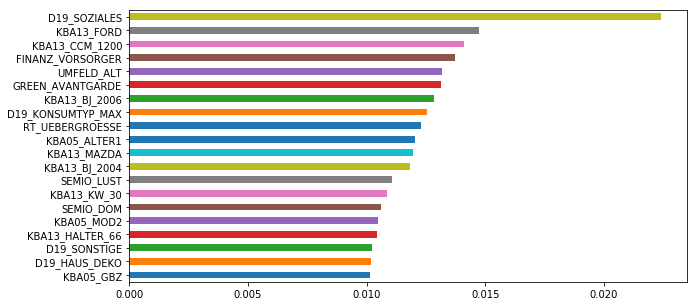

In [55]:
plt.figure(figsize=(10,5))
feat_importances = pd.Series(xgb_model_3.feature_importances_, index=mailout_train_v6.columns)
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh')
plt.show()

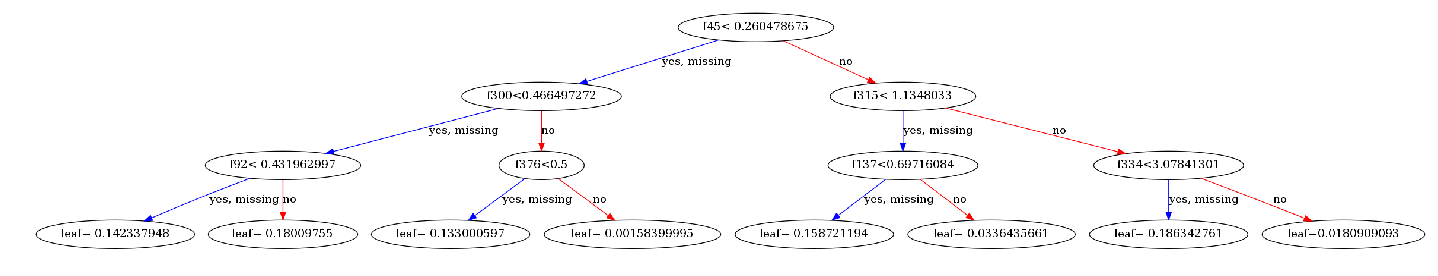

In [57]:
fig, ax = plt.subplots(1,1,figsize=(25, 35))
xgb.plot_tree(xgb_model_3, ax = ax)

### Optimize GradientBoostingClassifier

In [83]:
#Define model
n_estimators = 500
gb_model = GradientBoostingClassifier(n_estimators=n_estimators, validation_fraction=0.2, n_iter_no_change=10, random_state=42)

#Train model
gb_model.fit(X_train, y_train)

#Predict
y_pred = gb_model.predict_proba(X_test)[:,1]

#Summarize performance
print(roc_auc_score(y_test, y_pred))
print("best iteration: {0}".format(gb_model.n_estimators_))

0.7545323291259822
best iteration: 23


In [27]:
#Define parameters
parameters = {'learning_rate': [0.1, 0.2], 'n_estimators': [25, 50, 100, 250], 
              'max_depth': [3, 5], 'min_samples_split': [2, 4]}

GB_clf_model = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf_2 = GridSearchCV(GB_clf_model, parameters, n_jobs=1, cv=cv, scoring='roc_auc', verbose=2, refit=True)

clf_2.fit(mailout_train_v8, mailout_response)

# Get the estimator and predict
print("Best parameter (CV scorey=%0.3f):" % clf_2.best_score_)
print(clf_2.best_params_)
best_clf_2 = clf_2.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25, total=  26.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25, total=  21.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25, total=  21.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25, total=  20.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=25, total=  20.6s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=50, total=  41.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=50, total=  41.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=50 
[CV]  lear

[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100, total= 2.3min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100, total= 2.2min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100, total= 2.2min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100, total= 2.2min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=250 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=250, total= 5.5min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=250 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=250, total= 5.6min
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=250

[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25, total=  21.1s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25 
[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25, total=  20.9s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25 
[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25, total=  20.9s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25 
[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=25, total=  20.6s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=50, total=  42.2s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=50, total=  41.9s
[CV] learning_rate=0.2, max_depth=3, min_samples_split=4, n_estimators=50 
[CV]  lear

[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100, total= 2.1min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100, total= 2.1min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100, total= 2.1min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=100, total= 2.1min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=250 
[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=250, total= 5.3min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=250 
[CV]  learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=250, total= 5.4min
[CV] learning_rate=0.2, max_depth=5, min_samples_split=4, n_estimators=250

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 306.2min finished


Best parameter (CV score=0.762):
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 25}


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [24]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
mailout_test.shape

(42833, 366)

In [26]:
mailout_test_v2 = hp.replace_missing_data(mailout_test)

Successful replacement of incorrectly placed missing values


In [27]:
mailout_test_v3 = mailout_test_v2.drop(labels=excluded_columns, axis=1)
mailout_test_v3.shape

(42833, 351)

In [28]:
mailout_test_v4 = mailout_test_v3.drop(labels=["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE"], axis=1)
mailout_test_v4.shape

(42833, 349)

In [29]:
mailout_test_v4['CAMEO_DEUG_2015'] = mailout_test_v4.astype({'CAMEO_DEUG_2015': 'float'}).dtypes
mailout_test_v4['CAMEO_INTL_2015'] = mailout_test_v4.astype({'CAMEO_INTL_2015': 'float'}).dtypes
mailout_test_v5 = pd.get_dummies(mailout_test_v4, columns=['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ'], drop_first=True)
mailout_test_v5.shape

(42833, 389)

In [34]:
mailout_test_v6 = mailout_test_v5.drop(mailout_test_v5[to_drop], axis=1)
mailout_test_v6.shape 

(42833, 380)

In [35]:
mailout_test_LNR = mailout_test_v6.filter(items = ['LNR'], axis = 1)
mailout_test_v7 = mailout_test_v6.drop(['LNR'], axis = 1)
mailout_test_v7.shape #379 columns / same rows as beginning

(42833, 379)

In [36]:
# load the scaler and imputer
s_imp = load(open('s_imp.pkl', 'rb'))
KNNimp = load(open('KNNimp.pkl', 'rb'))
scaler = load(open('scaler.pkl', 'rb'))

In [39]:
mailout_test_v8 = hp.imputer_test(mailout_test_v7, KNNimp, s_imp, numerical, binary)

In [42]:
mailout_test_v9 = hp.standard_scaler_test(mailout_test_v8, scaler, numerical)

In [43]:
mailout_test_v9.shape

(42833, 379)

In [45]:
mailout_test_v9.describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
count,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000
mean,-0.000792,-0.001157,0.001900,-0.009612,0.004389,0.005532,-0.004289,0.011904,0.002490,-0.009028,...,0.038031,0.024117,0.030887,0.026452,0.010016,0.011300,0.010016,0.015455,0.009409,0.625055
std,0.999571,1.000424,0.980927,0.893173,1.011269,1.000837,1.007967,0.997487,0.991969,1.006707,...,0.191274,0.153414,0.173015,0.160476,0.099577,0.105699,0.099577,0.123357,0.096542,0.484114
min,-0.334298,-1.579690,-0.506791,-0.121330,-0.204996,-1.435695,-2.028423,-1.600200,-1.304785,-2.014370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.334298,-0.550273,-0.434194,-0.121330,-0.204996,-0.663368,-0.583792,-0.902142,-0.739023,-0.623638,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.334298,0.136005,-0.289001,-0.121330,-0.204996,-0.354438,0.035336,-0.104363,-0.173261,0.767094,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-0.219829,0.707903,0.161097,-0.121330,-0.204996,0.108958,1.067215,0.892862,0.958264,0.767094,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.244472,3.186130,27.007287,58.184765,19.029117,9.376877,6.226613,1.391475,1.524027,0.767094,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
from numpy import savetxt

# save to csv file
savetxt(r'/home/workspace/processed_test_data.csv', mailout_test_v9, delimiter=',')

In [47]:
mailout_test_v9.to_csv(r'/home/workspace/processed_test_data_dataframe.csv', index = False, header=True)

In [48]:
mailout_test_LNR.to_csv(r'/home/workspace/processed_test_LNRs.csv', index = False, header=True)

In [44]:
# load numpy array from csv file
from numpy import loadtxt

# load array
test_data = loadtxt(r'/home/workspace/processed_test_data.csv', delimiter=',')
mailout_test_v9 = test_data

In [33]:
mailout_test_LNR = pd.read_csv(r'/home/workspace/processed_test_LNRs.csv')
mailout_test_LNR.shape

(42833, 1)

In [ ]:
#load model (adjust accordingly and predict)
prediction_test_RF = xgb_model_3.predict_proba(mailout_test_v9)[:, 1]

In [59]:
mailout_test_LNR["RESPONSE"] = prediction_test_RF

In [60]:
mailout_test_LNR.head(10)

,LNR,RESPONSE
0,1754,0.217283
1,1770,0.256056
2,1465,0.024498
3,1470,0.055614
4,1478,0.071015
5,1782,0.024961
6,1485,0.046683
7,1519,0.264537
8,1835,0.145110
9,1522,0.080725


In [61]:
mailout_test_LNR.to_csv(r'/home/workspace/result_final_XGBoost_pred.csv', index = False, header=True)

In [45]:
#load model (adjust accordingly and predict)
prediction_test_GDB = best_clf_2.predict_proba(mailout_test_v9)[:, 1]

In [46]:
mailout_test_LNR["RESPONSE"] = prediction_test_GDB

In [47]:
mailout_test_LNR.head(10)

,LNR,RESPONSE
0,1754,0.030083
1,1770,0.026290
2,1465,0.006397
3,1470,0.005477
4,1478,0.004072
5,1782,0.004886
6,1485,0.004802
7,1519,0.021690
8,1835,0.019170
9,1522,0.005734


In [48]:
mailout_test_LNR.to_csv(r'/home/workspace/result_final_GDB_pred.csv', index = False, header=True)